### Fourier Transform on Convolution

Take

$$g(t) = \mathcal{F}_\nu^{-1}(G(\nu))(t) = \int_{-\infty}^{\infty} G(\nu) e^{2\pi i \nu t} d\nu$$

$$h(t) = \mathcal{F}_\nu^{-1}(H(\nu))(t) = \int_{-\infty}^{\infty} H(\nu) e^{2\pi i \nu t} d\nu$$

where $\mathcal{F}_\nu^{-1}(t)$ is the inverse Fourier transform. Then the convolution is

$$g*h = \int_{-\infty}^{\infty} h(t') g(t - t') dt'$$

$$= \int_{-\infty}^{\infty} h(t') \left( \int_{-\infty}^{\infty} G(\nu) e^{2\pi i \nu (t - t')} d\nu \right) dt'$$

which is also equal to,

$$g*h = \int_{-\infty}^{\infty} G(\nu) \left( \int_{-\infty}^{\infty} h(t') e^{-2\pi i \nu t'} dt' \right) e^{2\pi i \nu t} d\nu$$

$$= \int_{-\infty}^{\infty} G(\nu) H(\nu) e^{2\pi i \nu t} d\nu$$

$$= \mathcal{F}_\nu^{-1}[G(\nu)H(\nu)](t)$$

If we apply a Fourier transform to both side, the above becomes

$$\mathcal{F}(g*h) = \mathcal{F}(g) \mathcal{F}(h)$$



## Fast Fourier transform

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

Read and load the noisy image

In [257]:
# Open an image file
lena = Image.open('lenaNoise.png')

# Convert the image to a NumPy array
lena_array = np.array(lena)

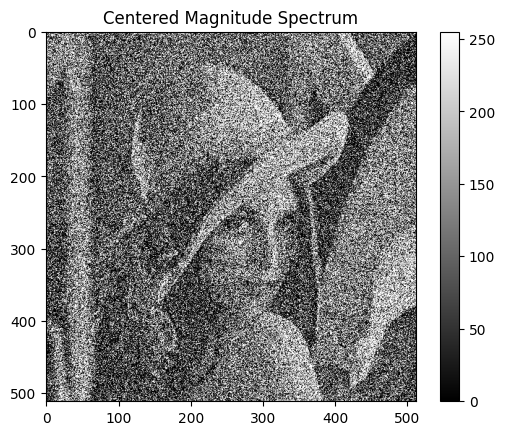

In [258]:
# Visualize the centered magnitude spectrum
plt.imshow(lena_array, cmap='gray')
plt.title('Centered Magnitude Spectrum')
plt.colorbar()
plt.show()

### (a)

Perform the Fourier transform and center the low frequencies

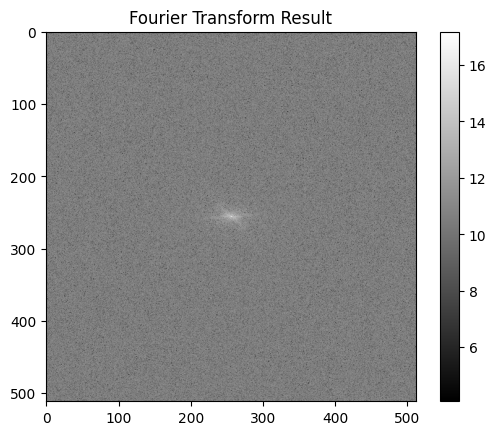

In [259]:
# Perform the 2D FFT on the grayscale image
fft_result = np.fft.fft2(lena_array)

# Shift the zero frequency components to the center
shifted_spectrum = np.fft.fftshift(fft_result)

# Calculate the magnitude spectrum
magnitude_spectrum = np.abs(shifted_spectrum)

# Visualize the centered magnitude spectrum
plt.imshow(np.log(1 + magnitude_spectrum), cmap='gray')
plt.title('Fourier Transform Result')
plt.colorbar()
plt.show()

### (b)

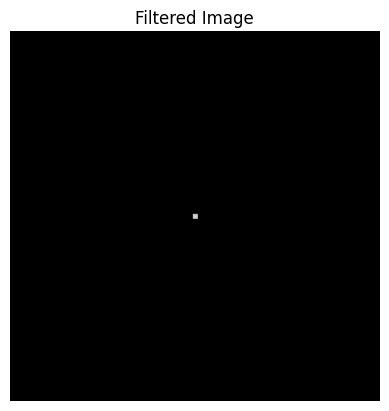

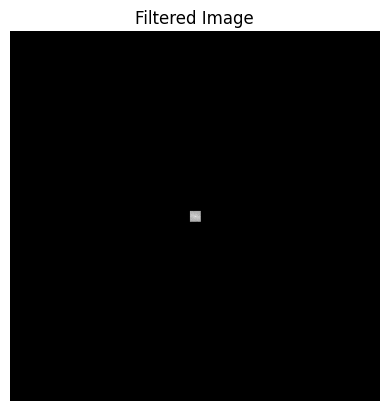

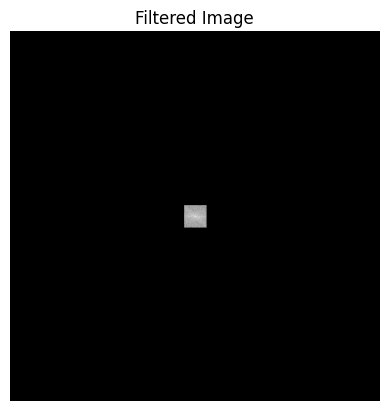

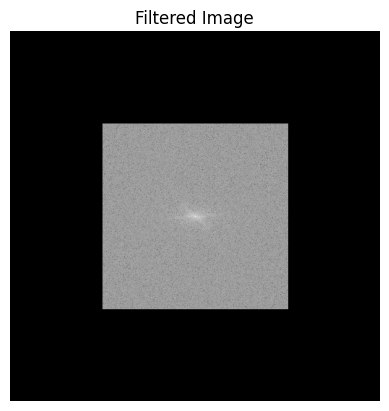

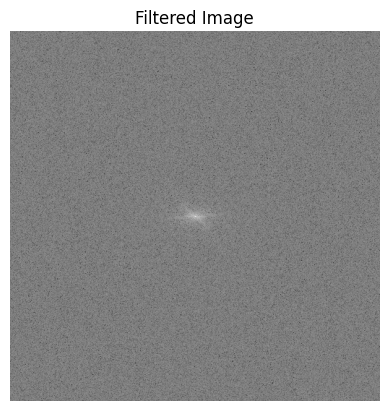

In [262]:
# Get the dimensions of the image and the centered spectrum
height, width = lena_array.shape
center_y, center_x = height // 2, width // 2

# Define the size of the square region to keep
square_sizes = [7, 15, 31, 256, 512]

#
filtered0 = []
spectrum = []

for square_size in square_sizes:
  # Create a mask to zero out frequencies outside the square region
  mask = np.zeros_like(magnitude_spectrum, dtype=np.uint8)
  mask[center_y - square_size // 2:center_y + square_size // 2 + 1,
      center_x - square_size // 2:center_x + square_size // 2 + 1] = 1

  # Apply the mask to the centered spectrum
  filtered0_spectrum = np.multiply(shifted_spectrum, mask)
  filtered0.append(filtered0_spectrum)

  filtered_spectrum = np.multiply(magnitude_spectrum, mask)
  spectrum.append(filtered_spectrum)

  # # Reverse the shift
  # ifft_shifted_spectrum = np.fft.ifftshift(filtered_spectrum)

  # # Compute the inverse FFT to obtain the filtered image
  # filtered_image = np.fft.ifft2(ifft_shifted_spectrum).real

  # Visualize the filtered image
  plt.imshow(np.log(1 + filtered_spectrum), cmap='gray')
  plt.title('Filtered Image')
  plt.axis('off')
  plt.show()

## (c)

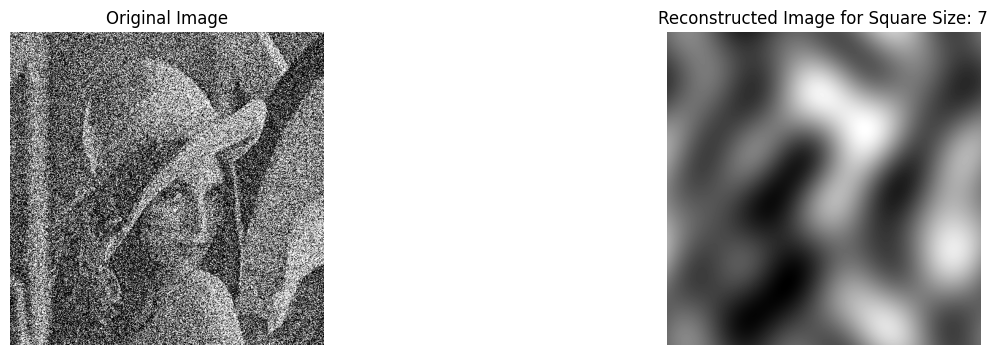

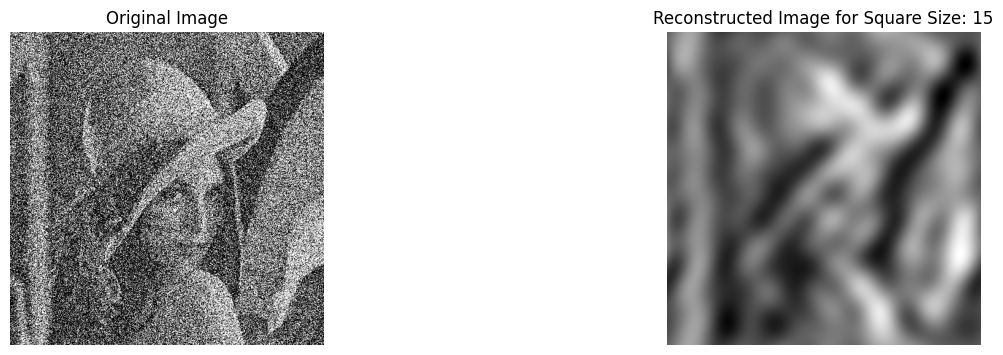

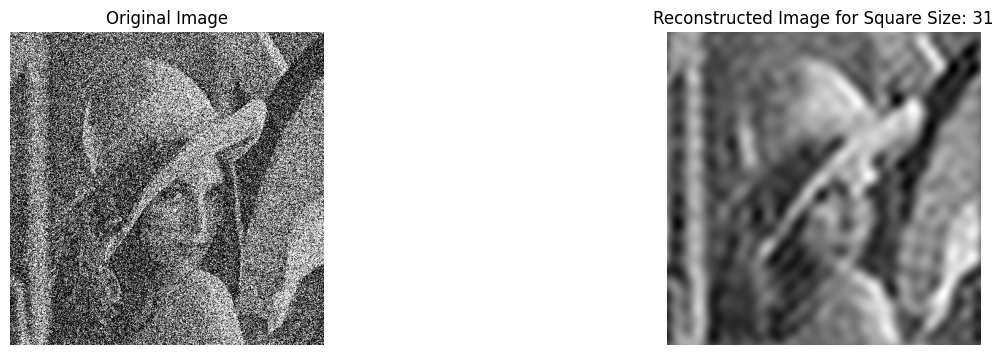

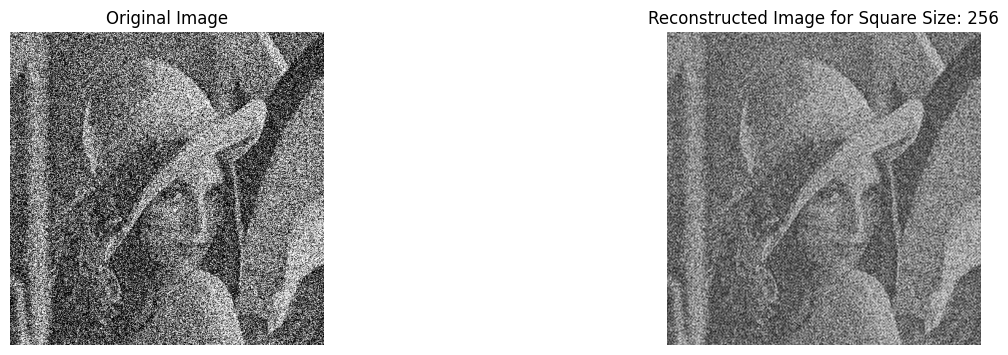

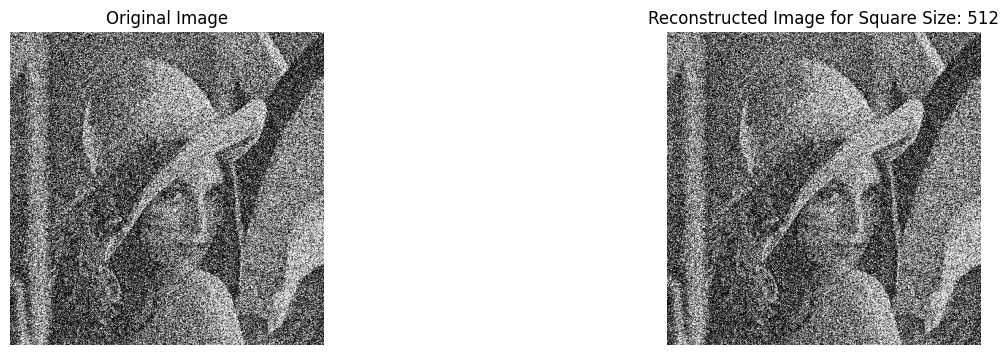

In [265]:
for i in range(0,5):
  # Reverse the shift to prepare for the inverse FFT
  ifft_shifted_spectrum = np.fft.ifftshift(filtered0[i])

  # Compute the inverse FFT to obtain the reconstructed image
  reconstructed_image = np.fft.ifft2(ifft_shifted_spectrum).real

  # Visualize the reconstructed image
  plt.figure(figsize=(10, 4))
  plt.subplot(1, 3, 1)
  plt.imshow(lena, cmap='gray')
  plt.title('Original Image')
  plt.axis('off')

  plt.subplot(1, 3, 3)
  plt.imshow(reconstructed_image, cmap='gray')
  plt.title(f'Reconstructed Image for Square Size: {square_sizes[i]}')
  plt.axis('off')

  plt.tight_layout()
  plt.show()

We observe that when the square of low frequency points kept has a small size, the reconstructed image is very blurry and unrecognizable, with only the most significant edges visible; However, if we keep most of the points, the reconstructed image will be almost identical to the noisy image, which means no denoising happening. Hence when the square size is reasonable, the effect of denoising would be ideal.

## Total Variation

#### Read and add noise to the Einstein image

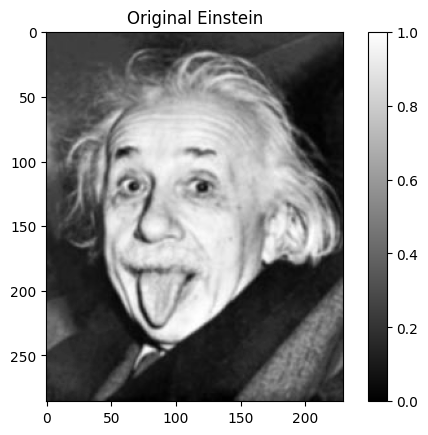

In [96]:
# Open an image file, convert to greyscale
einstein = Image.open('Einstein.jpeg').convert('L')

# Convert the image to a NumPy array
einstein_array = np.array(einstein)
# Normalize the pixel values to the range [0, 1]
einstein_array = einstein_array / 255.0

# Visualize the original Einstein
plt.imshow(einstein_array, cmap='gray')
plt.title('Original Einstein')
plt.colorbar()
plt.show()

Add noise to Einstein

In [166]:
import numpy as np
# specify gaussian parameters
mean = 0
sigmas = [0.001, 0.01, 0.1]

# construct gaussian noise matrices
noise = []
for sigma in sigmas:
  noise.append(np.random.normal(mean, sigma, np.shape(einstein_array)))

In [167]:
einstein_noisy_001 = einstein_array + noise[0]
einstein_noisy_01 = einstein_array + noise[1]
einstein_noisy_1 = einstein_array + noise[2]

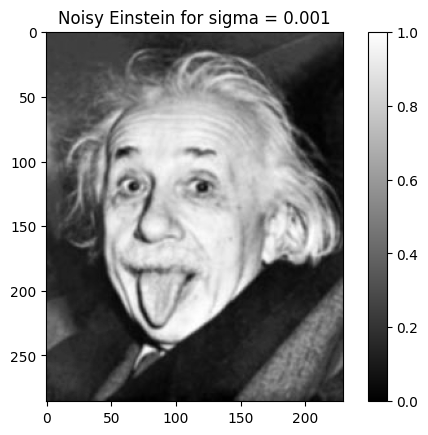

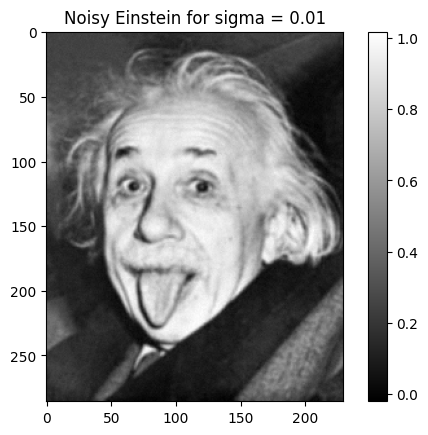

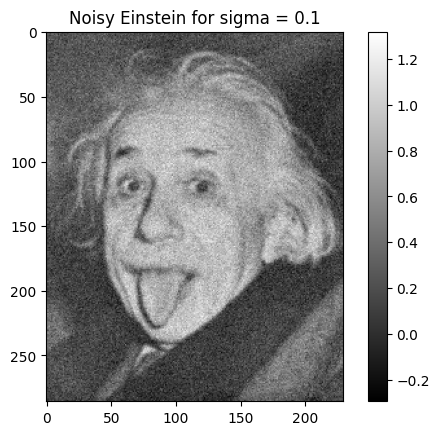

In [169]:
# Visualize noisy images
plt.imshow(einstein_noisy_001, cmap='gray')
plt.title('Noisy Einstein for sigma = {}'.format(0.001))
plt.colorbar()
plt.show()

plt.imshow(einstein_noisy_01, cmap='gray')
plt.title('Noisy Einstein for sigma = {}'.format(0.01))
plt.colorbar()
plt.show()

plt.imshow(einstein_noisy_1, cmap='gray')
plt.title('Noisy Einstein for sigma = {}'.format(0.1))
plt.colorbar()
plt.show()

### Implement objective function and gradients

Implement the objective function

In [180]:
def total_variation(image):
    # Calculate the Total Variation (TV) regularization term
    gradient_x = np.gradient(image, axis=1)
    gradient_y = np.gradient(image, axis=0)
    tv_term = np.sqrt(gradient_x**2 + gradient_y**2)

    return tv_term

In [181]:
def energy_function(denoised_image, noisy_image, lambda_data, lambda_tv):
    # Calculate the data fidelity term (L2 norm)
    data_term = np.linalg.norm(denoised_image - noisy_image)

    # Calculate the Total Variation (TV) regularization term
    tv = total_variation(denoised_image)

    # Calculate the energy function by combining the two terms
    energy = lambda_data * data_term + lambda_tv * np.sum(tv)
    return energy

Implement the gradients

In [171]:
# Compute the gradient for data fitting term
def data_fitting_gradient(noisy, denoised):
    return (-2)*(noisy - denoised)

In [178]:
def gradients(image):
    # Compute gradients in the x and y directions
    gradient_x = np.gradient(image, axis=1)
    gradient_y = np.gradient(image, axis=0)
    # Compute norms
    norm = np.sqrt(sum(np.square(gradient_x)) + sum(np.square(gradient_y)))

    return gradient_x / norm, gradient_y / norm

def compute_divergence(gradient_x, gradient_y):
    # Compute the second spatial derivatives
    gradient_x_x = np.gradient(gradient_x, axis=1)
    gradient_y_y = np.gradient(gradient_y, axis=0)

    # Calculate the divergence as the sum of second derivatives
    divergence = gradient_x_x + gradient_y_y
    return divergence

def compute_tv_gradient(image):
    # Compute the gradients of the image
    gradient_x, gradient_y = gradients(image)

    # Compute the divergence of the gradients
    divergence = compute_divergence(gradient_x, gradient_y)

    # Return the negative divergence as the TV gradient
    return -divergence

Implement gradient for the entire energy function

In [173]:
def compute_energy_gradient(denoised_image, noisy_image, lambda_fitting, lambda_tv):
    tv_gradient = compute_tv_gradient(denoised_image)
    data_term_gradient = data_fitting_gradient(noisy_image, denoised_image)

    # Combine gradients with the appropriate weights
    energy_gradient = lambda_fitting * data_term_gradient + lambda_tv * tv_gradient
    return energy_gradient

### Implement gradient descent

In [216]:
import matplotlib.pyplot as plt

def gradient_descent_denoise(noisy_image, lambda_fitting, lambda_tv, num_iterations, learning_rate, tau):
    # initialize iterations of energy function for plotting
    energy_values = []
    # Initialize the denoised image with the noisy image
    denoised_image = noisy_image.copy()

    for _ in range(num_iterations):
        # Compute the gradient of the energy function
        energy_gradient = compute_energy_gradient(denoised_image, noisy_image, lambda_fitting, lambda_tv)

        # Update the denoised image using gradient descent
        denoised_image -= learning_rate * energy_gradient

        # Perform gradient descent steps and update denoised_image
        # Calculate the energy function value and append it to energy_values
        energy = energy_function(denoised_image, noisy_image, lambda_fitting, lambda_tv)
        energy_values.append(energy)

        if (np.linalg.norm(denoised_image - noisy_image) <= tau):
          break

    return denoised_image, energy_values

### Tuning parameters

In [220]:
# initialize lists for tuning
energies = []
energies_plots = []
denoised = []

for lambda_fitting in np.arange(0.005, 0.5, 0.01):
  for learning_rate in np.arange(0.01, 0.1, 0.05):
    noisy_image = einstein_noisy_1  # Load the noisy image
    # lambda_fitting = 0.2
    lambda_tv = 1  # Regularization parameter for TV term. Since it is 1 in the problem, I used 1 here
    num_iterations = 1000  # Number of gradient descent iterations
    # learning_rate = 0.02  # Learning rate for gradient descent
    tau = 0.1 # Threshold for terminating

    # compute the denoised image
    denoised_image, energy_values = gradient_descent_denoise(noisy_image, lambda_fitting, lambda_tv, num_iterations, learning_rate, tau)
    # store all results
    energies.append(energy_function(denoised_image, noisy_image, lambda_fitting, lambda_tv))
    energies_plots.append(energy_values)
    denoised.append(denoised_image)

In [222]:
# Find the image with minimum energy function
min_index = energies.index(min(energies))

denoised_einstein_1 = denoised[min_index]
energy_convergence = energies_plots[min_index]

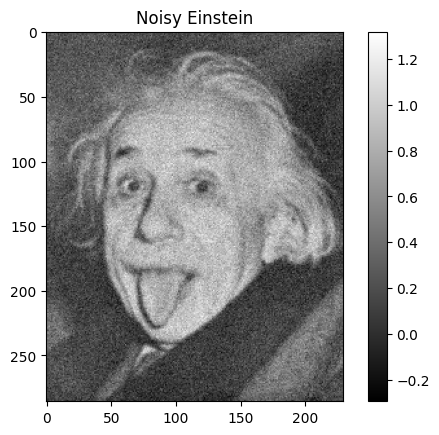

In [223]:
# Visualize the original Einstein
plt.imshow(einstein_noisy_1, cmap='gray')
plt.title('Noisy Einstein')
plt.colorbar()
plt.show()

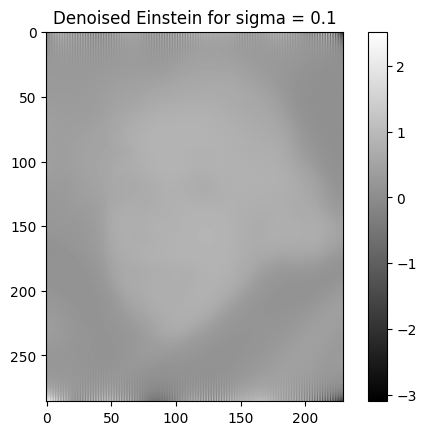

In [225]:
# Visualize the original Einstein
plt.imshow(denoised_einstein_1, cmap='gray')
plt.title('Denoised Einstein for sigma = 0.1')
plt.colorbar()
plt.show()

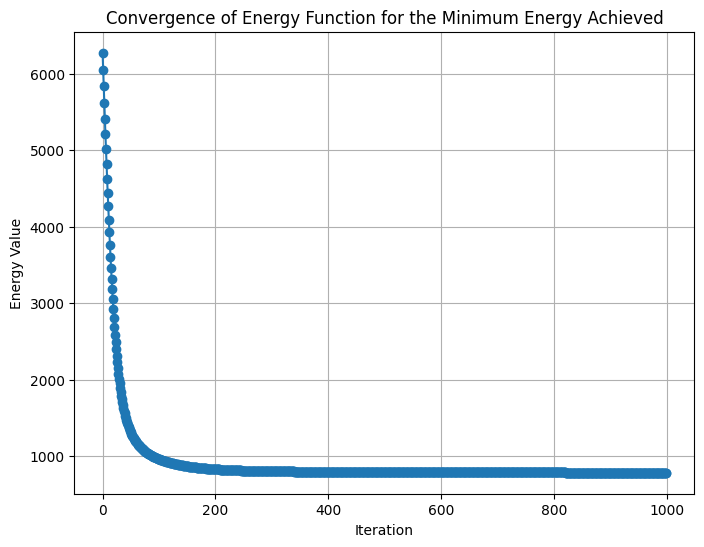

In [235]:
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
plt.plot(energy_convergence, marker='o', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('Energy Value')
plt.title('Convergence of Energy Function for the Minimum Energy Achieved')
plt.grid(True)
plt.show()

The image with the minimum energy does not seem to be very convincing. I don't know why. Here is an example for lambda = 0.16

In [248]:
# compute the denoised image
denoised_image, energy_values = gradient_descent_denoise(noisy_image, lambda_fitting = 0.16, lambda_tv = 1, num_iterations = 1000, learning_rate = 0.05, tau = 0.1)

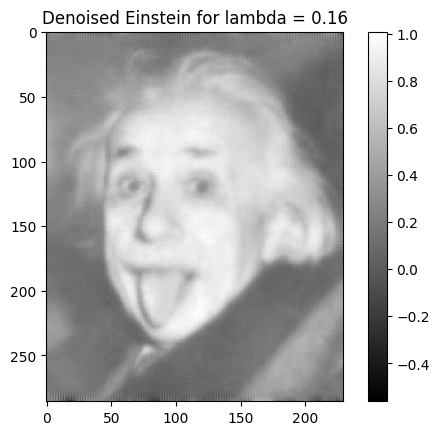

In [250]:
# Visualize the original Einstein
plt.imshow(denoised_image, cmap='gray')
plt.title('Denoised Einstein for lambda = 0.16')
plt.colorbar()
plt.show()

Results for sigma=0.001 and sigma=0.01

In [251]:
# compute the denoised image
noisy_image = einstein_noisy_001
denoised_einstein_001, energy_values = gradient_descent_denoise(noisy_image, lambda_fitting = 0.16, lambda_tv = 1, num_iterations = 1000, learning_rate = 0.05, tau = 0.1)

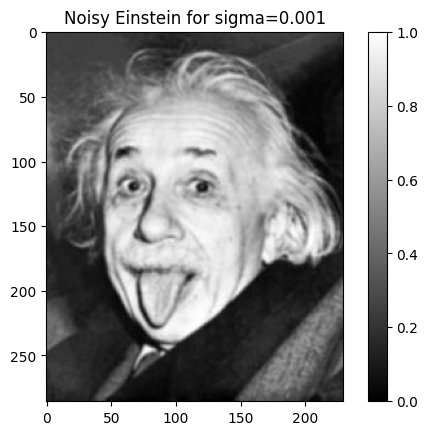

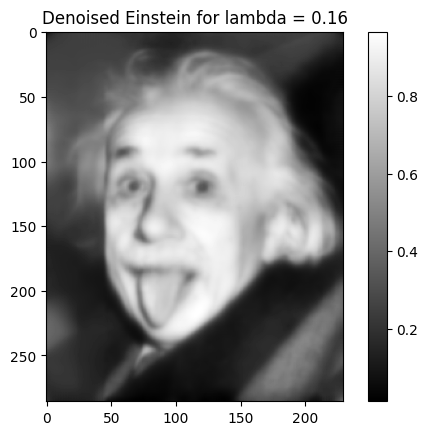

In [252]:
# Visualize the original Einstein
plt.imshow(einstein_noisy_001, cmap='gray')
plt.title('Noisy Einstein for sigma=0.001')
plt.colorbar()
plt.show()

# Visualize the original Einstein
plt.imshow(denoised_einstein_001, cmap='gray')
plt.title('Denoised Einstein for lambda = 0.16')
plt.colorbar()
plt.show()

In [253]:
# compute the denoised image
noisy_image = einstein_noisy_01
denoised_einstein_01, energy_values = gradient_descent_denoise(noisy_image, lambda_fitting = 0.16, lambda_tv = 1, num_iterations = 1000, learning_rate = 0.05, tau = 0.1)

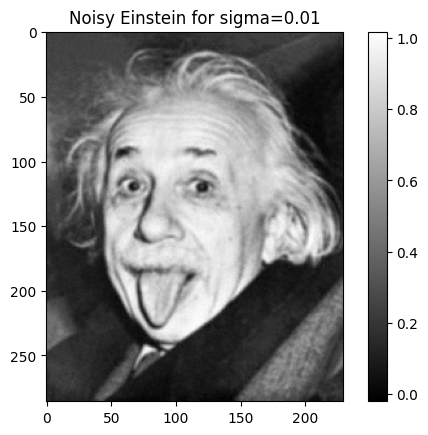

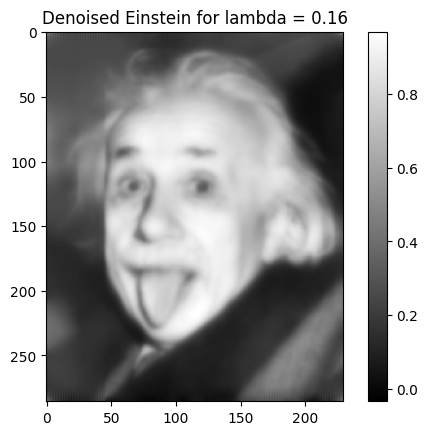

In [255]:
# Visualize the original Einstein
plt.imshow(einstein_noisy_01, cmap='gray')
plt.title('Noisy Einstein for sigma=0.01')
plt.colorbar()
plt.show()

# Visualize the original Einstein
plt.imshow(denoised_einstein_01, cmap='gray')
plt.title('Denoised Einstein for lambda = 0.16')
plt.colorbar()
plt.show()

We observe that the denoising generally eliminates most of the noise but also blurs the pictures. It preservesthe edges and shapes. As $\sigma$ for the noise becomes bigger, the denoising will have a much more blurry result. The noisy image with the biggest $\sigma=0.1$ also results in a very bright image.

We also observe that the convergence of the energy funtion is very fast in the beginning, and slows down as the iteration continues. However, it keeps decreasing and always hits the max iteration.

For no clear reason, the image with the lowest energy value does not look very promising. So I have to hand-pick a lambda to have the best result visually.